In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
from argparse import ArgumentParser
from double_net.double_net import DoubleNet, train_loop, train_loop_no_lagrange, test_loop
from double_net import datasets as ds
import time
import double_net.plot_utils as pu
import importlib
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
device

'cuda'

In [4]:
parser = ArgumentParser()
parser.add_argument('--random-seed', type=int, default=0)
parser.add_argument('--num-examples', type=int, default=131072 * 4)
parser.add_argument('--test-num-examples', type=int, default=2048 * 8)
parser.add_argument('--test-iter', type=int, default=5)
parser.add_argument('--n-agents', type=int, default=1)
parser.add_argument('--n-items', type=int, default=2)
parser.add_argument('--num-epochs', type=int, default=250)
parser.add_argument('--batch-size', type=int, default=128)
parser.add_argument('--test-batch-size', type=int, default=4096)
parser.add_argument('--model-lr', type=float, default=1e-3)
parser.add_argument('--misreport-lr', type=float, default=1e-1)
parser.add_argument('--misreport-iter', type=int, default=25)
parser.add_argument('--test-misreport-iter', type=int, default=2000)
parser.add_argument('--rho', type=float, default=1)
parser.add_argument('--rho-incr-iter', type=int, default=2)
parser.add_argument('--rho-incr-amount', type=float, default=1.0)
parser.add_argument('--lagr-update-iter', type=int, default=100)
parser.add_argument('--rgt-start', type=int, default=0)
parser.add_argument('--sinkhorn-epsilon', type=float, default=5e-2)
parser.add_argument('--sinkhorn-rounds', type=int, default=20)

dataset_name = ""
args = parser.parse_args(args=[])
args

Namespace(batch_size=128, lagr_update_iter=100, misreport_iter=25, misreport_lr=0.1, model_lr=0.001, n_agents=1, n_items=2, num_epochs=250, num_examples=524288, random_seed=0, rgt_start=0, rho=1, rho_incr_amount=1.0, rho_incr_iter=2, sinkhorn_epsilon=0.05, sinkhorn_rounds=20, test_batch_size=4096, test_iter=5, test_misreport_iter=2000, test_num_examples=16384)

In [5]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)

item_ranges = ds.preset_valuation_range(args.n_agents, args.n_items, dataset_name)
clamp_op = ds.get_clamp_op(item_ranges)

model = DoubleNet(
    args.n_agents, args.n_items, item_ranges, args.sinkhorn_epsilon, args.sinkhorn_rounds
).to(device)

train_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.num_examples, item_ranges).to(device)
train_loader = ds.Dataloader(train_data, batch_size=16384 * 8, shuffle=True)

In [6]:
%%time
train_loop(model, train_loader, args, device=device)

  0%|          | 1/250 [00:02<12:22,  2.98s/it]

{'regret_max': 0.23459309339523315, 'regret_mean': 0.06043311953544617, 'payment': 0.12088741362094879}


  1%|          | 2/250 [00:05<12:17,  2.97s/it]

{'regret_max': 0.05483890324831009, 'regret_mean': 0.01857582852244377, 'payment': 0.03844901919364929}


  1%|          | 3/250 [00:08<12:13,  2.97s/it]

{'regret_max': 0.026027776300907135, 'regret_mean': 0.0039924015291035175, 'payment': 0.017359832301735878}


  2%|▏         | 4/250 [00:11<12:09,  2.97s/it]

{'regret_max': 0.005701865069568157, 'regret_mean': 0.0007309168577194214, 'payment': 0.012825122103095055}


  2%|▏         | 5/250 [00:14<12:06,  2.96s/it]

{'regret_max': 0.007045059464871883, 'regret_mean': 0.0006844227900728583, 'payment': 0.04273273050785065}


  2%|▏         | 6/250 [00:17<12:03,  2.96s/it]

{'regret_max': 0.1011820137500763, 'regret_mean': 0.01863148808479309, 'payment': 0.1832236349582672}


  3%|▎         | 7/250 [00:20<12:00,  2.96s/it]

{'regret_max': 0.030243128538131714, 'regret_mean': 0.0028524650260806084, 'payment': 0.14134889841079712}


  3%|▎         | 8/250 [00:23<11:57,  2.96s/it]

{'regret_max': 0.08755356073379517, 'regret_mean': 0.009850701317191124, 'payment': 0.1971164345741272}


  4%|▎         | 9/250 [00:26<11:55,  2.97s/it]

{'regret_max': 0.05996108055114746, 'regret_mean': 0.004755173809826374, 'payment': 0.1800023764371872}


  4%|▍         | 10/250 [00:29<11:52,  2.97s/it]

{'regret_max': 0.0664299726486206, 'regret_mean': 0.006907429546117783, 'payment': 0.2099880874156952}


  4%|▍         | 11/250 [00:32<11:50,  2.97s/it]

{'regret_max': 0.05184397101402283, 'regret_mean': 0.003478382248431444, 'payment': 0.2083895206451416}


  5%|▍         | 12/250 [00:35<11:48,  2.97s/it]

{'regret_max': 0.02135041356086731, 'regret_mean': 0.004344065207988024, 'payment': 0.23461101949214935}


  5%|▌         | 13/250 [00:38<11:45,  2.98s/it]

{'regret_max': 0.053158700466156006, 'regret_mean': 0.006719761062413454, 'payment': 0.27264663577079773}


  6%|▌         | 14/250 [00:41<11:43,  2.98s/it]

{'regret_max': 0.15299680829048157, 'regret_mean': 0.018130403012037277, 'payment': 0.3552379310131073}


  6%|▌         | 15/250 [00:44<11:41,  2.98s/it]

{'regret_max': 0.11711516976356506, 'regret_mean': 0.009147554636001587, 'payment': 0.3262072503566742}


  6%|▋         | 16/250 [00:47<11:38,  2.99s/it]

{'regret_max': 0.11799421906471252, 'regret_mean': 0.006950889248400927, 'payment': 0.3204628825187683}


  7%|▋         | 17/250 [00:50<11:36,  2.99s/it]

{'regret_max': 0.1264648735523224, 'regret_mean': 0.009126340039074421, 'payment': 0.34512975811958313}


  7%|▋         | 18/250 [00:53<11:33,  2.99s/it]

{'regret_max': 0.11010104417800903, 'regret_mean': 0.007019004784524441, 'payment': 0.33721691370010376}


  8%|▊         | 19/250 [00:56<11:31,  2.99s/it]

{'regret_max': 0.1383078694343567, 'regret_mean': 0.009390706196427345, 'payment': 0.3539518713951111}


  8%|▊         | 20/250 [00:59<11:29,  3.00s/it]

{'regret_max': 0.13105708360671997, 'regret_mean': 0.007695724256336689, 'payment': 0.3467091917991638}


  8%|▊         | 21/250 [01:02<11:26,  3.00s/it]

{'regret_max': 0.10701805353164673, 'regret_mean': 0.006731368601322174, 'payment': 0.3404744267463684}


  9%|▉         | 22/250 [01:05<11:24,  3.00s/it]

{'regret_max': 0.11365395784378052, 'regret_mean': 0.0078239431604743, 'payment': 0.34825560450553894}


  9%|▉         | 23/250 [01:08<11:21,  3.00s/it]

{'regret_max': 0.1048048734664917, 'regret_mean': 0.007322579622268677, 'payment': 0.34504154324531555}


 10%|▉         | 24/250 [01:11<11:19,  3.00s/it]

{'regret_max': 0.11269855499267578, 'regret_mean': 0.007870585657656193, 'payment': 0.3499945402145386}


 10%|█         | 25/250 [01:14<11:16,  3.00s/it]

{'regret_max': 0.11141669750213623, 'regret_mean': 0.007229648530483246, 'payment': 0.3466911315917969}


 10%|█         | 26/250 [01:17<11:13,  3.01s/it]

{'regret_max': 0.10494458675384521, 'regret_mean': 0.0068505676463246346, 'payment': 0.3449372351169586}


 11%|█         | 27/250 [01:20<11:10,  3.01s/it]

{'regret_max': 0.10443305969238281, 'regret_mean': 0.006793010979890823, 'payment': 0.34493303298950195}


 11%|█         | 28/250 [01:23<11:07,  3.01s/it]

{'regret_max': 0.0982697606086731, 'regret_mean': 0.00656761322170496, 'payment': 0.34397631883621216}


 12%|█▏        | 29/250 [01:26<11:05,  3.01s/it]

{'regret_max': 0.09902113676071167, 'regret_mean': 0.006635134108364582, 'payment': 0.34566760063171387}


 12%|█▏        | 30/250 [01:29<11:04,  3.02s/it]

{'regret_max': 0.09559118747711182, 'regret_mean': 0.006403202656656504, 'payment': 0.3453594148159027}


 12%|█▏        | 31/250 [01:32<11:02,  3.03s/it]

{'regret_max': 0.09308844804763794, 'regret_mean': 0.006316116079688072, 'payment': 0.3464304208755493}


 13%|█▎        | 32/250 [01:35<11:01,  3.04s/it]

{'regret_max': 0.08785134553909302, 'regret_mean': 0.00611907709389925, 'payment': 0.3472071886062622}


 13%|█▎        | 33/250 [01:38<11:00,  3.04s/it]

{'regret_max': 0.08201020956039429, 'regret_mean': 0.0058447737246751785, 'payment': 0.348639577627182}


 14%|█▎        | 34/250 [01:41<10:57,  3.05s/it]

{'regret_max': 0.07299530506134033, 'regret_mean': 0.005461906548589468, 'payment': 0.35059335827827454}


 14%|█▍        | 35/250 [01:44<10:56,  3.06s/it]

{'regret_max': 0.062148451805114746, 'regret_mean': 0.005108742043375969, 'payment': 0.3546643555164337}


 14%|█▍        | 36/250 [01:48<10:55,  3.06s/it]

{'regret_max': 0.04416626691818237, 'regret_mean': 0.00453561544418335, 'payment': 0.3601842522621155}


 15%|█▍        | 37/250 [01:51<10:52,  3.06s/it]

{'regret_max': 0.021587073802947998, 'regret_mean': 0.004136541858315468, 'payment': 0.36878034472465515}


 15%|█▌        | 38/250 [01:54<10:50,  3.07s/it]

{'regret_max': 0.0205610990524292, 'regret_mean': 0.005581542383879423, 'payment': 0.3823838233947754}


 16%|█▌        | 39/250 [01:57<10:49,  3.08s/it]

{'regret_max': 0.024189233779907227, 'regret_mean': 0.00630329130217433, 'payment': 0.38518470525741577}


 16%|█▌        | 40/250 [02:00<10:46,  3.08s/it]

{'regret_max': 0.01757681369781494, 'regret_mean': 0.004458826966583729, 'payment': 0.3808010220527649}


 16%|█▋        | 41/250 [02:03<10:44,  3.08s/it]

{'regret_max': 0.01986593008041382, 'regret_mean': 0.0035010711289942265, 'payment': 0.37691766023635864}


 17%|█▋        | 42/250 [02:06<10:41,  3.08s/it]

{'regret_max': 0.01928013563156128, 'regret_mean': 0.0036813579499721527, 'payment': 0.3799942135810852}


 17%|█▋        | 43/250 [02:09<10:38,  3.08s/it]

{'regret_max': 0.01554572582244873, 'regret_mean': 0.0045205093920230865, 'payment': 0.38564541935920715}


 18%|█▊        | 44/250 [02:12<10:35,  3.09s/it]

{'regret_max': 0.014441370964050293, 'regret_mean': 0.004356284625828266, 'payment': 0.38596439361572266}


 18%|█▊        | 45/250 [02:15<10:33,  3.09s/it]

{'regret_max': 0.012537002563476562, 'regret_mean': 0.0036939112469553947, 'payment': 0.3839918375015259}


 18%|█▊        | 46/250 [02:18<10:30,  3.09s/it]

{'regret_max': 0.013369441032409668, 'regret_mean': 0.0035260948352515697, 'payment': 0.3842942714691162}


 19%|█▉        | 47/250 [02:22<10:27,  3.09s/it]

{'regret_max': 0.014381885528564453, 'regret_mean': 0.0037485864013433456, 'payment': 0.3866576850414276}


 19%|█▉        | 48/250 [02:25<10:25,  3.09s/it]

{'regret_max': 0.014075756072998047, 'regret_mean': 0.0037958454340696335, 'payment': 0.38815009593963623}


 20%|█▉        | 49/250 [02:28<10:22,  3.10s/it]

{'regret_max': 0.012323439121246338, 'regret_mean': 0.0035452002193778753, 'payment': 0.3880484700202942}


 20%|██        | 50/250 [02:31<10:19,  3.10s/it]

{'regret_max': 0.013266205787658691, 'regret_mean': 0.0036355117335915565, 'payment': 0.38989704847335815}


 20%|██        | 51/250 [02:34<10:16,  3.10s/it]

{'regret_max': 0.015466690063476562, 'regret_mean': 0.0033354940824210644, 'payment': 0.3892439305782318}


 21%|██        | 52/250 [02:37<10:14,  3.10s/it]

{'regret_max': 0.014424145221710205, 'regret_mean': 0.0033267734106630087, 'payment': 0.3905611038208008}


 21%|██        | 53/250 [02:40<10:10,  3.10s/it]

{'regret_max': 0.013769686222076416, 'regret_mean': 0.0033089537173509598, 'payment': 0.3917168974876404}


 22%|██▏       | 54/250 [02:43<10:07,  3.10s/it]

{'regret_max': 0.011250078678131104, 'regret_mean': 0.0031978911720216274, 'payment': 0.39240777492523193}


 22%|██▏       | 55/250 [02:46<10:04,  3.10s/it]

{'regret_max': 0.01238924264907837, 'regret_mean': 0.003242382314056158, 'payment': 0.39365702867507935}


 22%|██▏       | 56/250 [02:49<10:01,  3.10s/it]

{'regret_max': 0.01170647144317627, 'regret_mean': 0.0032175364904105663, 'payment': 0.39457815885543823}


 23%|██▎       | 57/250 [02:53<09:58,  3.10s/it]

{'regret_max': 0.013957500457763672, 'regret_mean': 0.0031983775552362204, 'payment': 0.39521995186805725}


 23%|██▎       | 58/250 [02:56<09:56,  3.11s/it]

{'regret_max': 0.019314110279083252, 'regret_mean': 0.003455983940511942, 'payment': 0.39529427886009216}


 24%|██▎       | 59/250 [02:59<09:53,  3.11s/it]

{'regret_max': 0.018145620822906494, 'regret_mean': 0.003677770495414734, 'payment': 0.39844733476638794}


 24%|██▍       | 60/250 [03:02<09:50,  3.11s/it]

{'regret_max': 0.014081001281738281, 'regret_mean': 0.00301791331730783, 'payment': 0.39562657475471497}


 24%|██▍       | 61/250 [03:05<09:47,  3.11s/it]

{'regret_max': 0.01647716760635376, 'regret_mean': 0.003526735585182905, 'payment': 0.3991807699203491}


 25%|██▍       | 62/250 [03:08<09:44,  3.11s/it]

{'regret_max': 0.014502763748168945, 'regret_mean': 0.003054067026823759, 'payment': 0.3974180817604065}


 25%|██▌       | 63/250 [03:11<09:40,  3.11s/it]

{'regret_max': 0.014916002750396729, 'regret_mean': 0.003298613242805004, 'payment': 0.3992813229560852}


 26%|██▌       | 64/250 [03:14<09:37,  3.11s/it]

{'regret_max': 0.013879060745239258, 'regret_mean': 0.0030604745261371136, 'payment': 0.3986527919769287}


 26%|██▌       | 65/250 [03:17<09:36,  3.12s/it]

{'regret_max': 0.014423131942749023, 'regret_mean': 0.003219232428818941, 'payment': 0.39984190464019775}


 26%|██▋       | 66/250 [03:21<09:33,  3.12s/it]

{'regret_max': 0.013091325759887695, 'regret_mean': 0.0030108217615634203, 'payment': 0.3992176055908203}


 27%|██▋       | 67/250 [03:24<09:30,  3.11s/it]

{'regret_max': 0.013591587543487549, 'regret_mean': 0.0031777031254023314, 'payment': 0.40045595169067383}


 27%|██▋       | 68/250 [03:27<09:26,  3.11s/it]

{'regret_max': 0.013546586036682129, 'regret_mean': 0.00300799822434783, 'payment': 0.3998914957046509}


 28%|██▊       | 69/250 [03:30<09:23,  3.11s/it]

{'regret_max': 0.01330113410949707, 'regret_mean': 0.003047245554625988, 'payment': 0.4004397988319397}


 28%|██▊       | 70/250 [03:33<09:20,  3.11s/it]

{'regret_max': 0.012542188167572021, 'regret_mean': 0.0030616149306297302, 'payment': 0.4008480906486511}


 28%|██▊       | 71/250 [03:36<09:17,  3.11s/it]

{'regret_max': 0.013258159160614014, 'regret_mean': 0.0030083172023296356, 'payment': 0.4007958471775055}


 29%|██▉       | 72/250 [03:39<09:14,  3.12s/it]

{'regret_max': 0.011902689933776855, 'regret_mean': 0.002975308336317539, 'payment': 0.40100446343421936}


 29%|██▉       | 73/250 [03:42<09:11,  3.12s/it]

{'regret_max': 0.012472569942474365, 'regret_mean': 0.0029591917991638184, 'payment': 0.40113145112991333}


 30%|██▉       | 74/250 [03:45<09:08,  3.12s/it]

{'regret_max': 0.013490498065948486, 'regret_mean': 0.0029535754583775997, 'payment': 0.40123677253723145}


 30%|███       | 75/250 [03:49<09:05,  3.12s/it]

{'regret_max': 0.01363295316696167, 'regret_mean': 0.0029679997824132442, 'payment': 0.4014628529548645}


 30%|███       | 76/250 [03:52<09:01,  3.11s/it]

{'regret_max': 0.016949832439422607, 'regret_mean': 0.002859859960153699, 'payment': 0.39937350153923035}


 31%|███       | 77/250 [03:55<08:58,  3.11s/it]

{'regret_max': 0.025072753429412842, 'regret_mean': 0.0040274932980537415, 'payment': 0.3991669714450836}


 31%|███       | 78/250 [03:58<08:55,  3.11s/it]

{'regret_max': 0.022670507431030273, 'regret_mean': 0.0031548612751066685, 'payment': 0.39969927072525024}


 32%|███▏      | 79/250 [04:01<08:52,  3.11s/it]

{'regret_max': 0.020606637001037598, 'regret_mean': 0.003614035900682211, 'payment': 0.40220293402671814}


 32%|███▏      | 80/250 [04:04<08:48,  3.11s/it]

{'regret_max': 0.019196927547454834, 'regret_mean': 0.0027192318812012672, 'payment': 0.3990781307220459}


 32%|███▏      | 81/250 [04:07<08:45,  3.11s/it]

{'regret_max': 0.016662120819091797, 'regret_mean': 0.002778282854706049, 'payment': 0.40029376745224}


 33%|███▎      | 82/250 [04:10<08:43,  3.11s/it]

{'regret_max': 0.014508187770843506, 'regret_mean': 0.0027310079894959927, 'payment': 0.4007234275341034}


 33%|███▎      | 83/250 [04:13<08:40,  3.11s/it]

{'regret_max': 0.015250980854034424, 'regret_mean': 0.002822134643793106, 'payment': 0.4012722969055176}


 34%|███▎      | 84/250 [04:17<08:36,  3.11s/it]

{'regret_max': 0.012988924980163574, 'regret_mean': 0.0027375435456633568, 'payment': 0.40143248438835144}


 34%|███▍      | 85/250 [04:20<08:33,  3.11s/it]

{'regret_max': 0.01308673620223999, 'regret_mean': 0.0025732298381626606, 'payment': 0.40061742067337036}


 34%|███▍      | 86/250 [04:23<08:30,  3.11s/it]

{'regret_max': 0.012272059917449951, 'regret_mean': 0.002543793525546789, 'payment': 0.40061330795288086}


 35%|███▍      | 87/250 [04:26<08:28,  3.12s/it]

{'regret_max': 0.012527048587799072, 'regret_mean': 0.0025855964049696922, 'payment': 0.40111544728279114}


 35%|███▌      | 88/250 [04:29<08:25,  3.12s/it]

{'regret_max': 0.012362658977508545, 'regret_mean': 0.0026096152141690254, 'payment': 0.40131431818008423}


 36%|███▌      | 89/250 [04:32<08:21,  3.12s/it]

{'regret_max': 0.011132776737213135, 'regret_mean': 0.0025614663027226925, 'payment': 0.40122073888778687}


 36%|███▌      | 90/250 [04:35<08:19,  3.12s/it]

{'regret_max': 0.011192381381988525, 'regret_mean': 0.002538041677325964, 'payment': 0.401233047246933}


 36%|███▋      | 91/250 [04:38<08:15,  3.12s/it]

{'regret_max': 0.011044561862945557, 'regret_mean': 0.0025246860459446907, 'payment': 0.4012317657470703}


 37%|███▋      | 92/250 [04:42<08:12,  3.12s/it]

{'regret_max': 0.010897815227508545, 'regret_mean': 0.002540177432820201, 'payment': 0.40145230293273926}


 37%|███▋      | 93/250 [04:45<08:09,  3.12s/it]

{'regret_max': 0.010702431201934814, 'regret_mean': 0.0025321657303720713, 'payment': 0.4015325903892517}


 38%|███▊      | 94/250 [04:48<08:06,  3.12s/it]

{'regret_max': 0.010469436645507812, 'regret_mean': 0.0024929556529968977, 'payment': 0.4013824462890625}


 38%|███▊      | 95/250 [04:51<08:03,  3.12s/it]

{'regret_max': 0.01042783260345459, 'regret_mean': 0.002506753895431757, 'payment': 0.40157589316368103}


 38%|███▊      | 96/250 [04:54<08:00,  3.12s/it]

{'regret_max': 0.010451793670654297, 'regret_mean': 0.0025040283799171448, 'payment': 0.40165233612060547}


 39%|███▉      | 97/250 [04:57<07:57,  3.12s/it]

{'regret_max': 0.01029515266418457, 'regret_mean': 0.002467724960297346, 'payment': 0.40151679515838623}


 39%|███▉      | 98/250 [05:00<07:54,  3.12s/it]

{'regret_max': 0.010467946529388428, 'regret_mean': 0.002494674874469638, 'payment': 0.4017927348613739}


 40%|███▉      | 99/250 [05:03<07:51,  3.12s/it]

{'regret_max': 0.010330379009246826, 'regret_mean': 0.0024735385086387396, 'payment': 0.40175360441207886}


 40%|████      | 100/250 [05:06<07:47,  3.12s/it]

{'regret_max': 0.010700762271881104, 'regret_mean': 0.002464931458234787, 'payment': 0.40178370475769043}


 40%|████      | 101/250 [05:10<07:44,  3.12s/it]

{'regret_max': 0.009936630725860596, 'regret_mean': 0.0022744121961295605, 'payment': 0.40058213472366333}


 41%|████      | 102/250 [05:13<07:41,  3.12s/it]

{'regret_max': 0.009660005569458008, 'regret_mean': 0.002305449452251196, 'payment': 0.40092799067497253}


 41%|████      | 103/250 [05:16<07:40,  3.13s/it]

{'regret_max': 0.009609758853912354, 'regret_mean': 0.0022728117182850838, 'payment': 0.40079984068870544}


 42%|████▏     | 104/250 [05:19<07:36,  3.13s/it]

{'regret_max': 0.009615302085876465, 'regret_mean': 0.0022204299457371235, 'payment': 0.4005107879638672}


 42%|████▏     | 105/250 [05:22<07:33,  3.13s/it]

{'regret_max': 0.010191559791564941, 'regret_mean': 0.0022713160142302513, 'payment': 0.40084633231163025}


 42%|████▏     | 106/250 [05:25<07:30,  3.13s/it]

{'regret_max': 0.009461522102355957, 'regret_mean': 0.0022367630153894424, 'payment': 0.4008041024208069}


 43%|████▎     | 107/250 [05:28<07:26,  3.12s/it]

{'regret_max': 0.00992518663406372, 'regret_mean': 0.0022562399972230196, 'payment': 0.4009646773338318}


 43%|████▎     | 108/250 [05:31<07:23,  3.12s/it]

{'regret_max': 0.009643495082855225, 'regret_mean': 0.002214582171291113, 'payment': 0.4008046090602875}


 44%|████▎     | 109/250 [05:35<07:19,  3.12s/it]

{'regret_max': 0.009246766567230225, 'regret_mean': 0.0022129227872937918, 'payment': 0.4009420573711395}


 44%|████▍     | 110/250 [05:38<07:16,  3.12s/it]

{'regret_max': 0.009302914142608643, 'regret_mean': 0.0022021341137588024, 'payment': 0.4009004235267639}


 44%|████▍     | 111/250 [05:41<07:14,  3.12s/it]

{'regret_max': 0.009810805320739746, 'regret_mean': 0.002220273483544588, 'payment': 0.400998055934906}


 45%|████▍     | 112/250 [05:44<07:11,  3.13s/it]

{'regret_max': 0.009715676307678223, 'regret_mean': 0.002231742488220334, 'payment': 0.40110671520233154}


 45%|████▌     | 113/250 [05:47<07:07,  3.12s/it]

{'regret_max': 0.009550988674163818, 'regret_mean': 0.002207315992563963, 'payment': 0.401161789894104}


 46%|████▌     | 114/250 [05:50<07:04,  3.12s/it]

{'regret_max': 0.009691953659057617, 'regret_mean': 0.0022109888959676027, 'payment': 0.4012419283390045}


 46%|████▌     | 115/250 [05:53<07:01,  3.12s/it]

{'regret_max': 0.009457647800445557, 'regret_mean': 0.0022091208957135677, 'payment': 0.4011216163635254}


 46%|████▋     | 116/250 [05:56<06:58,  3.12s/it]

{'regret_max': 0.010045409202575684, 'regret_mean': 0.002238223096355796, 'payment': 0.40131837129592896}


 47%|████▋     | 117/250 [06:00<06:55,  3.12s/it]

{'regret_max': 0.010006070137023926, 'regret_mean': 0.002180045936256647, 'payment': 0.4011459946632385}


 47%|████▋     | 118/250 [06:03<06:52,  3.12s/it]

{'regret_max': 0.009047746658325195, 'regret_mean': 0.0021691916044801474, 'payment': 0.4013248085975647}


 48%|████▊     | 119/250 [06:06<06:48,  3.12s/it]

{'regret_max': 0.009045124053955078, 'regret_mean': 0.0021466524340212345, 'payment': 0.4011853337287903}


 48%|████▊     | 120/250 [06:09<06:45,  3.12s/it]

{'regret_max': 0.010168731212615967, 'regret_mean': 0.002166470978409052, 'payment': 0.4012129604816437}


 48%|████▊     | 121/250 [06:12<06:41,  3.12s/it]

{'regret_max': 0.009996533393859863, 'regret_mean': 0.00223971763625741, 'payment': 0.40145134925842285}


 49%|████▉     | 122/250 [06:15<06:39,  3.12s/it]

{'regret_max': 0.009364485740661621, 'regret_mean': 0.0021853686776012182, 'payment': 0.40139681100845337}


 49%|████▉     | 123/250 [06:18<06:35,  3.11s/it]

{'regret_max': 0.009276270866394043, 'regret_mean': 0.0021674553863704205, 'payment': 0.4015786647796631}


 50%|████▉     | 124/250 [06:21<06:32,  3.12s/it]

{'regret_max': 0.009506404399871826, 'regret_mean': 0.0021711885929107666, 'payment': 0.40158069133758545}


 50%|█████     | 125/250 [06:25<06:30,  3.12s/it]

{'regret_max': 0.00914543867111206, 'regret_mean': 0.002116493647918105, 'payment': 0.4013732075691223}


 50%|█████     | 126/250 [06:28<06:26,  3.12s/it]

{'regret_max': 0.010229110717773438, 'regret_mean': 0.0019625057466328144, 'payment': 0.3997180461883545}


 51%|█████     | 127/250 [06:31<06:23,  3.12s/it]

{'regret_max': 0.018840551376342773, 'regret_mean': 0.0029351087287068367, 'payment': 0.39797332882881165}


 51%|█████     | 128/250 [06:34<06:19,  3.11s/it]

{'regret_max': 0.02274942398071289, 'regret_mean': 0.004151578061282635, 'payment': 0.401306688785553}


 52%|█████▏    | 129/250 [06:37<06:17,  3.12s/it]

{'regret_max': 0.019838333129882812, 'regret_mean': 0.003349099075421691, 'payment': 0.3954967260360718}


 52%|█████▏    | 130/250 [06:40<06:14,  3.12s/it]

{'regret_max': 0.02104419469833374, 'regret_mean': 0.0028581360820680857, 'payment': 0.3976466655731201}


 52%|█████▏    | 131/250 [06:43<06:11,  3.12s/it]

{'regret_max': 0.01714956760406494, 'regret_mean': 0.0029106754809617996, 'payment': 0.4017045795917511}


 53%|█████▎    | 132/250 [06:46<06:08,  3.12s/it]

{'regret_max': 0.015498518943786621, 'regret_mean': 0.0024494100362062454, 'payment': 0.3992692232131958}


 53%|█████▎    | 133/250 [06:49<06:05,  3.12s/it]

{'regret_max': 0.014571547508239746, 'regret_mean': 0.002264221664518118, 'payment': 0.3996899127960205}


 54%|█████▎    | 134/250 [06:53<06:02,  3.12s/it]

{'regret_max': 0.011848866939544678, 'regret_mean': 0.002225629286840558, 'payment': 0.4008657932281494}


 54%|█████▍    | 135/250 [06:56<05:59,  3.12s/it]

{'regret_max': 0.011287331581115723, 'regret_mean': 0.0020100660622119904, 'payment': 0.39991363883018494}


 54%|█████▍    | 136/250 [06:59<05:55,  3.12s/it]

{'regret_max': 0.011087357997894287, 'regret_mean': 0.0019502101931720972, 'payment': 0.3997945189476013}


 55%|█████▍    | 137/250 [07:02<05:52,  3.12s/it]

{'regret_max': 0.009820103645324707, 'regret_mean': 0.0019602077081799507, 'payment': 0.40031343698501587}


 55%|█████▌    | 138/250 [07:05<05:49,  3.12s/it]

{'regret_max': 0.009566903114318848, 'regret_mean': 0.0019022419583052397, 'payment': 0.40010228753089905}


 56%|█████▌    | 139/250 [07:08<05:46,  3.12s/it]

{'regret_max': 0.009071439504623413, 'regret_mean': 0.001887876307591796, 'payment': 0.40003758668899536}


 56%|█████▌    | 140/250 [07:11<05:43,  3.12s/it]

{'regret_max': 0.008879199624061584, 'regret_mean': 0.0019065585220232606, 'payment': 0.40032708644866943}


 56%|█████▋    | 141/250 [07:14<05:39,  3.12s/it]

{'regret_max': 0.009233862161636353, 'regret_mean': 0.0018921566661447287, 'payment': 0.40035438537597656}


 57%|█████▋    | 142/250 [07:18<05:39,  3.14s/it]

{'regret_max': 0.00868380069732666, 'regret_mean': 0.00187789520714432, 'payment': 0.4002447724342346}


 57%|█████▋    | 143/250 [07:21<05:35,  3.14s/it]

{'regret_max': 0.00854066014289856, 'regret_mean': 0.0018776915967464447, 'payment': 0.4002807140350342}


 58%|█████▊    | 144/250 [07:24<05:32,  3.13s/it]

{'regret_max': 0.008855968713760376, 'regret_mean': 0.0018748234724625945, 'payment': 0.40035590529441833}


 58%|█████▊    | 145/250 [07:27<05:28,  3.13s/it]

{'regret_max': 0.008640453219413757, 'regret_mean': 0.0018773229094222188, 'payment': 0.40040794014930725}


 58%|█████▊    | 146/250 [07:30<05:25,  3.13s/it]

{'regret_max': 0.008536010980606079, 'regret_mean': 0.001874776789918542, 'payment': 0.40041011571884155}


 59%|█████▉    | 147/250 [07:33<05:22,  3.13s/it]

{'regret_max': 0.008622676134109497, 'regret_mean': 0.0018599987961351871, 'payment': 0.40034613013267517}


 59%|█████▉    | 148/250 [07:36<05:18,  3.12s/it]

{'regret_max': 0.008531555533409119, 'regret_mean': 0.001870826818048954, 'payment': 0.40048569440841675}


 60%|█████▉    | 149/250 [07:40<05:15,  3.12s/it]

{'regret_max': 0.00863097608089447, 'regret_mean': 0.0018588113598525524, 'payment': 0.40041491389274597}


 60%|██████    | 150/250 [07:43<05:11,  3.12s/it]

{'regret_max': 0.008622676134109497, 'regret_mean': 0.001855301670730114, 'payment': 0.40042340755462646}


 60%|██████    | 151/250 [07:46<05:08,  3.12s/it]

{'regret_max': 0.008450880646705627, 'regret_mean': 0.0017365494277328253, 'payment': 0.3994833528995514}


 61%|██████    | 152/250 [07:49<05:05,  3.12s/it]

{'regret_max': 0.008272364735603333, 'regret_mean': 0.001731927040964365, 'payment': 0.3995518982410431}


 61%|██████    | 153/250 [07:52<05:02,  3.12s/it]

{'regret_max': 0.00819753110408783, 'regret_mean': 0.0017050860915333033, 'payment': 0.39936524629592896}


 62%|██████▏   | 154/250 [07:55<04:59,  3.12s/it]

{'regret_max': 0.0080299973487854, 'regret_mean': 0.0016974874306470156, 'payment': 0.3993155360221863}


 62%|██████▏   | 155/250 [07:58<04:56,  3.12s/it]

{'regret_max': 0.00817728042602539, 'regret_mean': 0.0017039017984643579, 'payment': 0.3994055390357971}


 62%|██████▏   | 156/250 [08:01<04:53,  3.12s/it]

{'regret_max': 0.008126989006996155, 'regret_mean': 0.0017010425217449665, 'payment': 0.3994196653366089}


 63%|██████▎   | 157/250 [08:04<04:50,  3.12s/it]

{'regret_max': 0.00813409686088562, 'regret_mean': 0.0016947798430919647, 'payment': 0.3994038999080658}


 63%|██████▎   | 158/250 [08:08<04:47,  3.12s/it]

{'regret_max': 0.008099257946014404, 'regret_mean': 0.001683037611655891, 'payment': 0.3993322551250458}


 64%|██████▎   | 159/250 [08:11<04:43,  3.12s/it]

{'regret_max': 0.008108779788017273, 'regret_mean': 0.0016802743775770068, 'payment': 0.3993535339832306}


 64%|██████▍   | 160/250 [08:14<04:40,  3.12s/it]

{'regret_max': 0.008138373494148254, 'regret_mean': 0.0016817705472931266, 'payment': 0.3993932008743286}


 64%|██████▍   | 161/250 [08:17<04:37,  3.12s/it]

{'regret_max': 0.00816209614276886, 'regret_mean': 0.001664839219301939, 'payment': 0.39929717779159546}


 65%|██████▍   | 162/250 [08:20<04:34,  3.12s/it]

{'regret_max': 0.008164718747138977, 'regret_mean': 0.0016757380217313766, 'payment': 0.399406760931015}


 65%|██████▌   | 163/250 [08:23<04:31,  3.12s/it]

{'regret_max': 0.008126258850097656, 'regret_mean': 0.0016651360783725977, 'payment': 0.39935141801834106}


 66%|██████▌   | 164/250 [08:26<04:28,  3.12s/it]

{'regret_max': 0.008200272917747498, 'regret_mean': 0.0016636672662571073, 'payment': 0.39933475852012634}


 66%|██████▌   | 165/250 [08:29<04:25,  3.12s/it]

{'regret_max': 0.008141770958900452, 'regret_mean': 0.0016726767644286156, 'payment': 0.39943963289260864}


 66%|██████▋   | 166/250 [08:33<04:22,  3.13s/it]

{'regret_max': 0.008180275559425354, 'regret_mean': 0.0016476032324135303, 'payment': 0.3993126451969147}


 67%|██████▋   | 167/250 [08:36<04:19,  3.12s/it]

{'regret_max': 0.008211195468902588, 'regret_mean': 0.0016593215987086296, 'payment': 0.3994031548500061}


 67%|██████▋   | 168/250 [08:39<04:15,  3.12s/it]

{'regret_max': 0.00821329653263092, 'regret_mean': 0.0016543599776923656, 'payment': 0.3993879556655884}


 68%|██████▊   | 169/250 [08:42<04:12,  3.12s/it]

{'regret_max': 0.008262082934379578, 'regret_mean': 0.0016342451563104987, 'payment': 0.39929768443107605}


 68%|██████▊   | 170/250 [08:45<04:09,  3.12s/it]

{'regret_max': 0.008282750844955444, 'regret_mean': 0.0016588671132922173, 'payment': 0.39945220947265625}


 68%|██████▊   | 171/250 [08:48<04:06,  3.12s/it]

{'regret_max': 0.008315250277519226, 'regret_mean': 0.0016496892785653472, 'payment': 0.3994702696800232}


 69%|██████▉   | 172/250 [08:51<04:03,  3.12s/it]

{'regret_max': 0.008346930146217346, 'regret_mean': 0.0016279362607747316, 'payment': 0.39933180809020996}


 69%|██████▉   | 173/250 [08:54<04:00,  3.12s/it]

{'regret_max': 0.008241921663284302, 'regret_mean': 0.001625554170459509, 'payment': 0.3993290066719055}


 70%|██████▉   | 174/250 [08:58<03:57,  3.12s/it]

{'regret_max': 0.008249491453170776, 'regret_mean': 0.0016332746017724276, 'payment': 0.3993852436542511}


 70%|███████   | 175/250 [09:01<03:54,  3.12s/it]

{'regret_max': 0.008257105946540833, 'regret_mean': 0.0016344465548172593, 'payment': 0.3994654715061188}


 70%|███████   | 176/250 [09:04<03:51,  3.12s/it]

{'regret_max': 0.008206367492675781, 'regret_mean': 0.001528342952951789, 'payment': 0.39858439564704895}


 71%|███████   | 177/250 [09:07<03:47,  3.12s/it]

{'regret_max': 0.008070781826972961, 'regret_mean': 0.00150432123336941, 'payment': 0.39845284819602966}


 71%|███████   | 178/250 [09:10<03:44,  3.12s/it]

{'regret_max': 0.008021131157875061, 'regret_mean': 0.0015210886485874653, 'payment': 0.3986004590988159}


 72%|███████▏  | 179/250 [09:13<03:41,  3.12s/it]

{'regret_max': 0.008101657032966614, 'regret_mean': 0.0015522476751357317, 'payment': 0.3986104726791382}


 72%|███████▏  | 180/250 [09:16<03:40,  3.14s/it]

{'regret_max': 0.009333431720733643, 'regret_mean': 0.001963535323739052, 'payment': 0.3983462452888489}


 72%|███████▏  | 181/250 [09:19<03:36,  3.14s/it]

{'regret_max': 0.012139558792114258, 'regret_mean': 0.0024396246299147606, 'payment': 0.3957790732383728}


 73%|███████▎  | 182/250 [09:23<03:32,  3.13s/it]

{'regret_max': 0.012519776821136475, 'regret_mean': 0.002427197527140379, 'payment': 0.39839205145835876}


 73%|███████▎  | 183/250 [09:26<03:29,  3.13s/it]

{'regret_max': 0.01056644320487976, 'regret_mean': 0.0020674297120422125, 'payment': 0.397360622882843}


 74%|███████▎  | 184/250 [09:29<03:26,  3.13s/it]

{'regret_max': 0.010136812925338745, 'regret_mean': 0.001759529346600175, 'payment': 0.39798516035079956}


 74%|███████▍  | 185/250 [09:32<03:23,  3.13s/it]

{'regret_max': 0.011098623275756836, 'regret_mean': 0.0019514764426276088, 'payment': 0.398385226726532}


 74%|███████▍  | 186/250 [09:35<03:19,  3.12s/it]

{'regret_max': 0.008563578128814697, 'regret_mean': 0.0015709218569099903, 'payment': 0.3969780206680298}


 75%|███████▍  | 187/250 [09:38<03:16,  3.13s/it]

{'regret_max': 0.008759558200836182, 'regret_mean': 0.0015828500036150217, 'payment': 0.3976520299911499}


 75%|███████▌  | 188/250 [09:41<03:13,  3.12s/it]

{'regret_max': 0.008827880024909973, 'regret_mean': 0.001554258051328361, 'payment': 0.3984968960285187}


 76%|███████▌  | 189/250 [09:44<03:10,  3.12s/it]

{'regret_max': 0.008881628513336182, 'regret_mean': 0.0016072803409770131, 'payment': 0.39878514409065247}


 76%|███████▌  | 190/250 [09:48<03:07,  3.12s/it]

{'regret_max': 0.00815090537071228, 'regret_mean': 0.0014804638922214508, 'payment': 0.3981649577617645}


 76%|███████▋  | 191/250 [09:51<03:04,  3.12s/it]

{'regret_max': 0.008174583315849304, 'regret_mean': 0.0014588432386517525, 'payment': 0.3980365991592407}


 77%|███████▋  | 192/250 [09:54<03:00,  3.12s/it]

{'regret_max': 0.008210152387619019, 'regret_mean': 0.0014664842747151852, 'payment': 0.39827507734298706}


 77%|███████▋  | 193/250 [09:57<02:57,  3.12s/it]

{'regret_max': 0.008000895380973816, 'regret_mean': 0.0014906844589859247, 'payment': 0.3985714912414551}


 78%|███████▊  | 194/250 [10:00<02:54,  3.12s/it]

{'regret_max': 0.008116886019706726, 'regret_mean': 0.0014825058169662952, 'payment': 0.39852291345596313}


 78%|███████▊  | 195/250 [10:03<02:51,  3.12s/it]

{'regret_max': 0.007867604494094849, 'regret_mean': 0.0014397483319044113, 'payment': 0.39824244379997253}


 78%|███████▊  | 196/250 [10:06<02:48,  3.12s/it]

{'regret_max': 0.008047625422477722, 'regret_mean': 0.0014495321083813906, 'payment': 0.3983336091041565}


 79%|███████▉  | 197/250 [10:09<02:45,  3.12s/it]

{'regret_max': 0.00793527066707611, 'regret_mean': 0.0014540964039042592, 'payment': 0.39838680624961853}


 79%|███████▉  | 198/250 [10:12<02:42,  3.12s/it]

{'regret_max': 0.007901936769485474, 'regret_mean': 0.0014489891473203897, 'payment': 0.3983752727508545}


 80%|███████▉  | 199/250 [10:16<02:39,  3.12s/it]

{'regret_max': 0.007921412587165833, 'regret_mean': 0.0014326341915875673, 'payment': 0.3982962667942047}


 80%|████████  | 200/250 [10:19<02:35,  3.12s/it]

{'regret_max': 0.00790281593799591, 'regret_mean': 0.0014358597109094262, 'payment': 0.39832836389541626}


 80%|████████  | 201/250 [10:22<02:33,  3.12s/it]

{'regret_max': 0.007936343550682068, 'regret_mean': 0.0013650787295773625, 'payment': 0.3976326286792755}


 81%|████████  | 202/250 [10:25<02:29,  3.12s/it]

{'regret_max': 0.0076774656772613525, 'regret_mean': 0.001331296400167048, 'payment': 0.397429883480072}


 81%|████████  | 203/250 [10:28<02:26,  3.13s/it]

{'regret_max': 0.007661715149879456, 'regret_mean': 0.0013513130834326148, 'payment': 0.39762789011001587}


 82%|████████▏ | 204/250 [10:31<02:23,  3.12s/it]

{'regret_max': 0.007619604468345642, 'regret_mean': 0.0013428614474833012, 'payment': 0.397565633058548}


 82%|████████▏ | 205/250 [10:34<02:20,  3.12s/it]

{'regret_max': 0.0075182318687438965, 'regret_mean': 0.0013280916027724743, 'payment': 0.3974671959877014}


 82%|████████▏ | 206/250 [10:37<02:17,  3.12s/it]

{'regret_max': 0.007481008768081665, 'regret_mean': 0.0013249877374619246, 'payment': 0.39742815494537354}


 83%|████████▎ | 207/250 [10:41<02:14,  3.12s/it]

{'regret_max': 0.007508993148803711, 'regret_mean': 0.0013213132042437792, 'payment': 0.3974001407623291}


 83%|████████▎ | 208/250 [10:44<02:11,  3.12s/it]

{'regret_max': 0.007484897971153259, 'regret_mean': 0.0013168466975912452, 'payment': 0.3973870277404785}


 84%|████████▎ | 209/250 [10:47<02:07,  3.12s/it]

{'regret_max': 0.007565245032310486, 'regret_mean': 0.0013097072951495647, 'payment': 0.39735275506973267}


 84%|████████▍ | 210/250 [10:50<02:04,  3.12s/it]

{'regret_max': 0.00755387544631958, 'regret_mean': 0.001327960635535419, 'payment': 0.3975173830986023}


 84%|████████▍ | 211/250 [10:53<02:01,  3.12s/it]

{'regret_max': 0.007612675428390503, 'regret_mean': 0.0013048541732132435, 'payment': 0.39736175537109375}


 85%|████████▍ | 212/250 [10:56<01:58,  3.12s/it]

{'regret_max': 0.007419362664222717, 'regret_mean': 0.0013104540994390845, 'payment': 0.3974090814590454}


 85%|████████▌ | 213/250 [10:59<01:55,  3.12s/it]

{'regret_max': 0.0076363831758499146, 'regret_mean': 0.00131608871743083, 'payment': 0.3974410891532898}


 86%|████████▌ | 214/250 [11:02<01:52,  3.12s/it]

{'regret_max': 0.0074008554220199585, 'regret_mean': 0.0012860202696174383, 'payment': 0.39721471071243286}


 86%|████████▌ | 215/250 [11:06<01:49,  3.12s/it]

{'regret_max': 0.0075363218784332275, 'regret_mean': 0.001313973218202591, 'payment': 0.3974498212337494}


 86%|████████▋ | 216/250 [11:09<01:46,  3.12s/it]

{'regret_max': 0.007576838135719299, 'regret_mean': 0.0013019879115745425, 'payment': 0.3973749876022339}


 87%|████████▋ | 217/250 [11:12<01:42,  3.12s/it]

{'regret_max': 0.0074802786111831665, 'regret_mean': 0.0012864324962720275, 'payment': 0.39727410674095154}


 87%|████████▋ | 218/250 [11:15<01:39,  3.12s/it]

{'regret_max': 0.007568031549453735, 'regret_mean': 0.0013113528257235885, 'payment': 0.3974643349647522}


 88%|████████▊ | 219/250 [11:18<01:37,  3.15s/it]

{'regret_max': 0.007570162415504456, 'regret_mean': 0.0012836968526244164, 'payment': 0.39727580547332764}


 88%|████████▊ | 220/250 [11:21<01:34,  3.15s/it]

{'regret_max': 0.007416829466819763, 'regret_mean': 0.001292025321163237, 'payment': 0.39735257625579834}


 88%|████████▊ | 221/250 [11:24<01:30,  3.14s/it]

{'regret_max': 0.0074854642152786255, 'regret_mean': 0.0012910959776490927, 'payment': 0.3973359167575836}


 89%|████████▉ | 222/250 [11:27<01:27,  3.13s/it]

{'regret_max': 0.0074232518672943115, 'regret_mean': 0.0012776443036273122, 'payment': 0.39724966883659363}


 89%|████████▉ | 223/250 [11:31<01:24,  3.12s/it]

{'regret_max': 0.007597297430038452, 'regret_mean': 0.0012951557291671634, 'payment': 0.39740514755249023}


 90%|████████▉ | 224/250 [11:34<01:21,  3.12s/it]

{'regret_max': 0.00751204788684845, 'regret_mean': 0.0012762738624587655, 'payment': 0.39727944135665894}


 90%|█████████ | 225/250 [11:37<01:18,  3.12s/it]

{'regret_max': 0.0074819475412368774, 'regret_mean': 0.0012923086760565639, 'payment': 0.39740225672721863}


 90%|█████████ | 226/250 [11:40<01:14,  3.12s/it]

{'regret_max': 0.007409155368804932, 'regret_mean': 0.0012038217391818762, 'payment': 0.3965315818786621}


 91%|█████████ | 227/250 [11:43<01:11,  3.13s/it]

{'regret_max': 0.007324486970901489, 'regret_mean': 0.001211828552186489, 'payment': 0.3966439664363861}


 91%|█████████ | 228/250 [11:46<01:08,  3.12s/it]

{'regret_max': 0.007168203592300415, 'regret_mean': 0.0012050813529640436, 'payment': 0.3966289758682251}


 92%|█████████▏| 229/250 [11:49<01:05,  3.12s/it]

{'regret_max': 0.00727669894695282, 'regret_mean': 0.0012006601318717003, 'payment': 0.39657503366470337}


 92%|█████████▏| 230/250 [11:52<01:02,  3.12s/it]

{'regret_max': 0.0072480738162994385, 'regret_mean': 0.0011866220738738775, 'payment': 0.3964681923389435}


 92%|█████████▏| 231/250 [11:56<00:59,  3.12s/it]

{'regret_max': 0.007190778851509094, 'regret_mean': 0.0012019550194963813, 'payment': 0.3965868353843689}


 93%|█████████▎| 232/250 [11:59<00:56,  3.12s/it]

{'regret_max': 0.007228583097457886, 'regret_mean': 0.0011716554872691631, 'payment': 0.39636778831481934}


 93%|█████████▎| 233/250 [12:02<00:52,  3.12s/it]

{'regret_max': 0.00720427930355072, 'regret_mean': 0.0012014214880764484, 'payment': 0.3965972065925598}


 94%|█████████▎| 234/250 [12:05<00:49,  3.12s/it]

{'regret_max': 0.00717577338218689, 'regret_mean': 0.0011691320687532425, 'payment': 0.39635729789733887}


 94%|█████████▍| 235/250 [12:08<00:46,  3.12s/it]

{'regret_max': 0.007260337471961975, 'regret_mean': 0.0011924745049327612, 'payment': 0.3965270519256592}


 94%|█████████▍| 236/250 [12:11<00:43,  3.12s/it]

{'regret_max': 0.007008284330368042, 'regret_mean': 0.0011630052467808127, 'payment': 0.3963100016117096}


 95%|█████████▍| 237/250 [12:14<00:40,  3.12s/it]

{'regret_max': 0.007207334041595459, 'regret_mean': 0.001181131461635232, 'payment': 0.39647895097732544}


 95%|█████████▌| 238/250 [12:17<00:37,  3.12s/it]

{'regret_max': 0.00711020827293396, 'regret_mean': 0.0011733782012015581, 'payment': 0.3964216411113739}


 96%|█████████▌| 239/250 [12:21<00:34,  3.12s/it]

{'regret_max': 0.007086560130119324, 'regret_mean': 0.0011719483882188797, 'payment': 0.3964200019836426}


 96%|█████████▌| 240/250 [12:24<00:31,  3.12s/it]

{'regret_max': 0.007095664739608765, 'regret_mean': 0.0011628975626081228, 'payment': 0.39636170864105225}


 96%|█████████▋| 241/250 [12:27<00:28,  3.12s/it]

{'regret_max': 0.007112756371498108, 'regret_mean': 0.001171410083770752, 'payment': 0.3964306712150574}


 97%|█████████▋| 242/250 [12:30<00:24,  3.12s/it]

{'regret_max': 0.007083982229232788, 'regret_mean': 0.0011737747117877007, 'payment': 0.3964678645133972}


 97%|█████████▋| 243/250 [12:33<00:21,  3.12s/it]

{'regret_max': 0.007063865661621094, 'regret_mean': 0.001156603917479515, 'payment': 0.39635348320007324}


 98%|█████████▊| 244/250 [12:36<00:18,  3.12s/it]

{'regret_max': 0.00705304741859436, 'regret_mean': 0.0011679272865876555, 'payment': 0.39643359184265137}


 98%|█████████▊| 245/250 [12:39<00:15,  3.12s/it]

{'regret_max': 0.0070473551750183105, 'regret_mean': 0.0011570738861337304, 'payment': 0.3963661193847656}


 98%|█████████▊| 246/250 [12:42<00:12,  3.12s/it]

{'regret_max': 0.0070931315422058105, 'regret_mean': 0.0011577426921576262, 'payment': 0.3963730037212372}


 99%|█████████▉| 247/250 [12:45<00:09,  3.12s/it]

{'regret_max': 0.007111638784408569, 'regret_mean': 0.00116990995593369, 'payment': 0.3964778184890747}


 99%|█████████▉| 248/250 [12:49<00:06,  3.12s/it]

{'regret_max': 0.007079184055328369, 'regret_mean': 0.00115183275192976, 'payment': 0.3963276743888855}


100%|█████████▉| 249/250 [12:52<00:03,  3.13s/it]

{'regret_max': 0.0070045143365859985, 'regret_mean': 0.0011515871156007051, 'payment': 0.39634066820144653}


100%|██████████| 250/250 [12:55<00:00,  3.10s/it]

{'regret_max': 0.0070945024490356445, 'regret_mean': 0.0011506162118166685, 'payment': 0.39634644985198975}
CPU times: user 10min 59s, sys: 1min 53s, total: 12min 53s
Wall time: 12min 55s


In [7]:
%%time
# model.sinkhorn_rounds = 100
# model.sinkhorn_epsilon = 1e-2
test_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device)
test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop(model, test_loader, args, device=device)
result

CPU times: user 2min 19s, sys: 333 ms, total: 2min 20s
Wall time: 2min 20s


{'payment_mean': 0.39754238724708557,
 'regret_mean': 0.0023646452464163303,
 'regret_max': 0.008842021226882935}

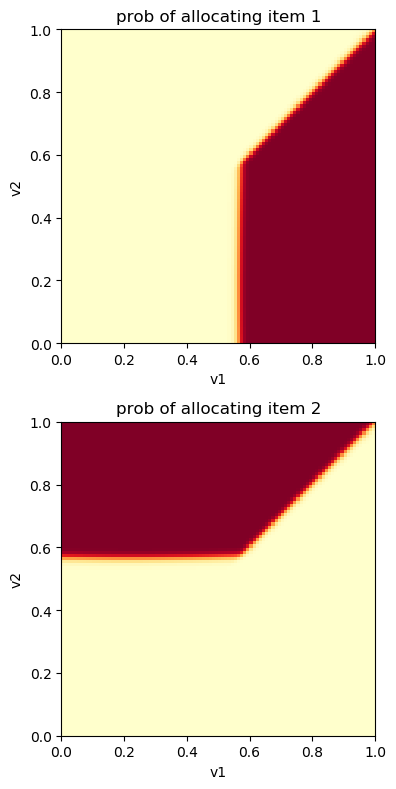

In [8]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
model.sinkhorn_rounds = 100
model.sinkhorn_epsilon = 1e-2
pu.plot_12_model(model.to(device='cpu'), 0.01, (0,1), (0,1))